In [66]:
from collections import defaultdict
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from processing.preprocessing import BCIDataProcessor
import mne


class SSVEP_CCA_Classifier:
    def __init__(self, sampling_rate=250, frequencies=(8, 11, 15), num_targets=3, n_components=1):
        self.frequencies = frequencies
        self.sampling_rate = sampling_rate
        self.num_targets = num_targets
        self.n_components = n_components

    def get_reference_signals(self, length, target_freq):
        """Generate sine and cosine templates (1st & 2nd harmonics) for a given frequency."""
        t = np.arange(0, length / self.sampling_rate, 1.0 / self.sampling_rate)
        ref = np.array([
            np.sin(2 * np.pi * target_freq * t),
            np.cos(2 * np.pi * target_freq * t),
            # np.sin(4 * np.pi * target_freq * t),
            # np.cos(4 * np.pi * target_freq * t)
        ])
        return ref

    def find_corr(self, eeg_data, references, n_components=1):
        """Perform CCA between EEG and reference signals for each frequency."""
        cca = CCA(n_components=n_components)
        # cca = CCA(n_components=n_components, scale=False, tol=1e-12, max_iter=1000)
        result = np.zeros(references.shape[0])

        for i in range(references.shape[0]):
            cca.fit(eeg_data.T, references[i].T)
            X_c, Y_c = cca.transform(eeg_data.T, references[i].T)
            corr = [np.corrcoef(X_c[:, j], Y_c[:, j])[0, 1] for j in range(n_components)]
            result[i] = np.max(corr)

        return result

    def predict(self, X):
        """Classify the EEG signals using CCA."""
        predictions = []
        for eeg_data in X:
            length = eeg_data.shape[1]
            references = np.array([
                self.get_reference_signals(length, freq)
                for freq in self.frequencies
            ])
            correlations = self.find_corr(eeg_data, references, self.n_components)
            predicted_class = self.frequencies[np.argmax(correlations)]
            predicted_class = f'{predicted_class:.1f}'
            predictions.append(predicted_class)
        return np.array(predictions)

In [71]:
recording_path_1 = '../recordings/recording_ssvep1.raw.fif'
recording_path_2 = '../recordings/recording_ssvep2.raw.fif'
recording_path_3 = '../recordings/recording_ssvep4_gel.raw.fif'
rescale = True
window_size = 4
window_overlap = 0
filter_method = 'fir'
l_freq, h_freq = 7, 31

processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process(channels=(5, 6, 7))
# Only select 8.0 and 11.0
# data = {label: data[label] for label in data.keys() if label in ['8.0', '11.0']}
data

{'11.0': array([[[ 3.66514946e-17, -3.78600566e-05, -6.53891074e-05, ...,
           4.16776171e-06,  7.34256224e-07, -4.16303417e-06],
         [ 5.80631223e-18, -1.76140820e-05, -2.96684894e-05, ...,
          -5.16132991e-06, -3.04570267e-06, -9.88888389e-07],
         [ 1.85988056e-17, -1.33565180e-05, -2.19467367e-05, ...,
          -1.09074778e-05, -6.35148183e-06, -1.35644626e-06]],
 
        [[-8.63760544e-06, -1.09012691e-05, -1.00562858e-05, ...,
          -3.61729416e-06, -2.59640251e-06, -1.26562120e-06],
         [ 4.66373774e-07,  1.10769353e-06,  1.11980726e-06, ...,
           2.49892506e-07,  2.79941273e-07,  8.93640826e-08],
         [ 1.79303461e-06,  2.12525785e-06,  2.82133282e-07, ...,
           1.50935162e-06,  1.94866283e-06,  1.75236481e-06]],
 
        [[-7.09472358e-07, -1.87974615e-06, -4.86198311e-06, ...,
           1.36897806e-05,  1.42517139e-05,  1.57200249e-05],
         [-3.87464779e-07, -1.24072201e-06, -2.35461228e-06, ...,
           1.87947498e-0

In [72]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X.shape, y.shape

((180, 3, 250), (180,))

In [73]:
import numpy as np
from sklearn.metrics import accuracy_score

classifier = SSVEP_CCA_Classifier(sampling_rate=250, frequencies=[11, 8, 15], num_targets=3, n_components=1)
y_pred = classifier.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Classification Accuracy: {acc * 100:.2f}%")

Classification Accuracy: 49.44%


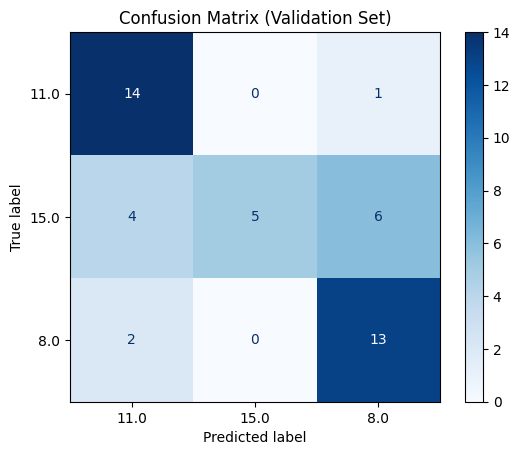

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()